Epoch 1/50 completed. Loss: 6622.09228515625
Epoch 2/50 completed. Loss: 5029.044921875
Epoch 3/50 completed. Loss: 4076.099365234375
Epoch 4/50 completed. Loss: 3600.565185546875
Epoch 5/50 completed. Loss: 3532.2177734375
Epoch 6/50 completed. Loss: 3431.454345703125
Epoch 7/50 completed. Loss: 3219.86181640625
Epoch 8/50 completed. Loss: 2905.53955078125
Epoch 9/50 completed. Loss: 2725.13232421875
Epoch 10/50 completed. Loss: 2652.01513671875
Epoch 11/50 completed. Loss: 2917.947265625
Epoch 12/50 completed. Loss: 2871.36181640625
Epoch 13/50 completed. Loss: 2616.47412109375
Epoch 14/50 completed. Loss: 2537.78466796875
Epoch 15/50 completed. Loss: 2489.181640625
Epoch 16/50 completed. Loss: 2395.95849609375
Epoch 17/50 completed. Loss: 2368.80224609375
Epoch 18/50 completed. Loss: 2464.05029296875
Epoch 19/50 completed. Loss: 2327.735595703125
Epoch 20/50 completed. Loss: 2446.684326171875
Epoch 21/50 completed. Loss: 2325.04931640625
Epoch 22/50 completed. Loss: 2100.15942382812

Epoch 50/50 completed. Loss: 1893.04150390625


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


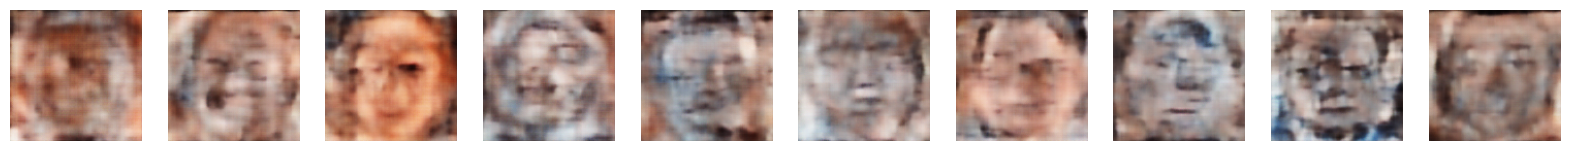

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU, Conv2D, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Define paths and categories
data_dir = 'C:/Users/dhill/VS-Code/dataset'
categories = ['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Function to load images from a directory
def load_images_from_category(category, data_dir):
    images = []
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(128, 128))  # Adjust target_size as needed
        image = img_to_array(image)
        images.append(image)
    return np.array(images)

# Load images for each category
data = {}
for category in categories:
    data[category] = load_images_from_category(category, data_dir)

# Normalize images to [-1, 1]
for category in categories:
    data[category] = (data[category].astype(np.float32) - 127.5) / 127.5

# Combine all data into one dataset
all_data = np.concatenate([data[category] for category in categories])

# Define the dimensions of the latent space
latent_dim = 100

# Define the encoder model
def build_encoder(input_shape, latent_dim):
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(encoder_input)
    x = LeakyReLU()(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    encoder = Model(encoder_input, [z_mean, z_log_var], name='encoder')
    return encoder

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define the decoder model
def build_decoder(latent_dim, output_shape):
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(16 * 16 * 128, activation='relu')(decoder_input)
    x = Reshape((16, 16, 128))(x)
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    decoder_output = Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='tanh')(x)
    decoder = Model(decoder_input, decoder_output, name='decoder')
    return decoder

# Build the VAE model
input_shape = (128, 128, 3)
encoder = build_encoder(input_shape, latent_dim)
z_mean, z_log_var = encoder.output
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
decoder = build_decoder(latent_dim, input_shape)
reconstructed_img = decoder(z)

vae = Model(encoder.input, reconstructed_img, name='vae')

# Define the VAE loss
mse_loss = tf.keras.losses.MeanSquaredError()

def vae_loss(x, reconstructed_x, z_mean, z_log_var):
    reconstruction_loss = mse_loss(tf.keras.backend.flatten(x), tf.keras.backend.flatten(reconstructed_x))
    reconstruction_loss *= 128 * 128 * 3
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile the VAE model
optimizer = Adam()

# Custom training loop
epochs = 50
batch_size = 64
num_batches = all_data.shape[0] // batch_size

for epoch in range(epochs):
    for batch_idx in range(num_batches):
        batch = all_data[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = encoder(batch)
            z = sampling([z_mean, z_log_var])
            reconstructed_batch = decoder(z)
            loss = vae_loss(batch, reconstructed_batch, z_mean, z_log_var)
        gradients = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    print(f"Epoch {epoch + 1}/{epochs} completed. Loss: {loss.numpy()}")

# Save the encoder and decoder models
encoder.save('vae_encoder.h5')
decoder.save('vae_decoder.h5')

# Example: Generate new images
n = 10  # Number of images to generate
random_latent_vectors = np.random.normal(size=(n, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

# Display generated images
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow((generated_images[i] * 127.5 + 127.5).astype(np.uint8))
    plt.axis('off')
plt.show()
